# Introduction

Some scripts to use for mission planning in Kerbal Space Program with the Real Solar System mod, or if you're just curious about spacecraft maneuvers. Most every input is done in kilograms, meters, and seconds. Excepting where primary sources are in other units (e.g. rotation periods in hours). Outputs are generally in the same, excepting the plotting functions which assume some user desires (altitudes in kilometers). Uses a few basic formulas (vis-viva, K3L, etc) and planetary information (https://nssdc.gsfc.nasa.gov/planetary/factsheet/ and others for dwarfs) to calculate transfer orbits around various solar system bodies.

Depending on the flight profile of the mission, the user may need to tweak some things. However in a general sense transfer_orbit2 can handle most anything. While the method transfer_orbit3 is the closest to the common sense flight profile without thrust termination for say an early comm sat. The method orbital_insertion will return the initial Pe for use with PVG on a mission given dV available and the target orbit.

These first few cells will just load some libraries, define the Planet class, and initialize almost all the bodies in the Solar system in that class.

In [22]:
import numpy as np
import matplotlib.pyplot as plt

print('\n'.join(f'{m.__name__}=={m.__version__}' for m in globals().values() if getattr(m, '__version__', None)))

numpy==1.19.2


In [23]:
class Planet:
    
    M_Sun = 1.9885e30
    R_Sun = 695.7e6
    T_Sun = 5772
    G = 6.67430e-11

    
    def __init__(self, name, mass, radius, sma, period):
        # Mostly self explanatory, note that period is the rotational period and not the orbital period
        self.name = name
        self.mass = mass
        self.radius = radius
        self.sma = sma
        self.period = period
        self.soi = self.sma*(self.mass/Planet.M_Sun)**(2/5)
        self.stationary_alt = np.cbrt(Planet.G * self.mass/(4*np.pi**2)*self.period**2)-self.radius
        self.surface_gravity = Planet.G * self.mass/self.radius**2
        self.escape_velocity = np.sqrt(2*Planet.G*self.mass/self.radius)

    def semimajor(self,r1,r2):
        return (r1+r2+2*self.radius)/2
    
    def vis_viva(self,r,a):
        return np.sqrt(Planet.G * self.mass * (2/r - 1/a))
    
    def vis_viva_a(self,r,v):
        return 1/(2/r - v**2/(Planet.G * self.mass))
    
    def orbital_insertion(self,dv,pe_f,ap_f):
        # Takes the available kick stage dv, the target periapsis (r0), and the target final apoapsis. 
        # Calculates the necessary target Pe for the orbit before kick stage assuming pe_f is the initial Ap
        # af = self.semimajor(pe_f,ap_f)
        # burnout_speed = self.vis_viva(pe_f+self.radius,af)-dv
        # a0 = self.vis_viva_a(pe_f+self.radius,burnout_speed)
        # target_pe = 2*a0-2*self.radius-pe_f
        return 2*self.vis_viva_a(pe_f+self.radius,self.vis_viva(pe_f+self.radius,self.semimajor(pe_f,ap_f))-dv)-2*self.radius-pe_f
    
    def transfer_orbit(self,r0,a0,af):
        # Strictly formal version of the transfer problem in terms of semimajor axes and Vis-Viva
        return self.vis_viva(r0+self.radius,af)-self.vis_viva(r0+self.radius,a0)

    def transfer_orbit2(self,r0,pe_i,ap_i,pe_f,ap_f):
        # The more KSP friendly version in terms of periapsis and apoapsis
        # does not assume injection happens at target Pe, hence we can float all 5 terms here
        a0 = self.semimajor(pe_i,ap_i); af = self.semimajor (pe_f,ap_f)
        return self.transfer_orbit(r0,a0,af)
    
    def transfer_orbit3(self,pe_i,ap_i,ap_f):
        # The most directly KSP useful form of this problem
        # Assumes injection Ap is target Pe
        a0=self.semimajor(pe_i,ap_i);af = self.semimajor(ap_i,ap_f)
        return self.transfer_orbit(ap_i,a0,af)
    
    def plot_transfers(self,pe_i, ap_i, ap_f):
        # Plots the needed dV for a range of injection Pe and a given desired orbit
        # Assumes injection Ap is your desired target Pe
        # Use np.linspace(min,max,nsteps) to define a suitable range for the injection Pe
        # The reverse problem of target Pe given a dV and target orbit is probably also useful, but a job for another day
        injection_dV=self.transfer_orbit2(ap_i,pe_i,ap_i,ap_i,ap_f)
        plt.figure(figsize=(14,8))
        plt.plot(injection_dV,pe_i/1e3)
        plt.ylabel('Injection Periapsis (km)', fontsize=16);plt.xlabel(r'Injection $\Delta$V (m/s)', fontsize = 16)
        plt.title('Target Orbit ('+ self.name + '): ' + str(ap_i/1e3) + ' by ' + str(ap_f/1e3)+' km',fontsize=16)
        plt.xticks(fontsize=16);plt.yticks(fontsize=16);plt.grid(True)
        plt.show()
        
    def equilibrium_temp(self,Ab):
        # Mostly pointless way to set equilibbrium temperature of a body given the bond albedo
        # These numbers will basically never match the actual temperature b/c it neglects some important mechanisms
        self.T_eq = Planet.T_Sun*np.sqrt(Planet.R_Sun/(2*self.sma))*(1-Ab)**(1/4)
        
    def magnetopause_height(self,rho_sw,v_sw,B):
        # This requires some inputs for some fairly variable parameters
        return 
        
    def target_AP(self,e,target_pe):
        # Quick & dirty utility to get the Ap for a given Pe and eccentricity
        # If the reverse  problem is desirable just flip the numerator/denominator of the eccentricity term
        return (self.radius+target_pe)*(1+e)/(1-e)-self.radius
    
    def orbit_sma_for_P(self,T):
        # Simple Kepler's 3rd law to convert a desired period of rotation into a semimajor axis
        return np.cbrt(Planet.G*self.mass / (4*np.pi**2) * T**2)
    
    def print_stats(self):
        print('The surface gravity on {0} is: {1:.2f} m/s^2'.format(self.name,self.surface_gravity))
        print('The edge of the sphere of influence of {0} is: {1:.2f} Mm'.format(self.name,self.soi/1e6))
        print('The stationary altitude for satellites of {0} is: {1:.2f} km'.format(self.name,self.stationary_alt/1e3))
        if self.stationary_alt > self.soi: print('    NOTE: This stationary altitude exceeds the sphere of influence')
        print('The escape velocity from the geometric surface of {0} is {1:.2f} m/s'.format(self.name,self.escape_velocity))
        
    def print_vis_viva(self,r,a):
        print('The speed of a satellite orbiting {0} with a semimajor axis of {1:.1f} km at an altitude of {2:.1f} km is: {3:.2f} m/s'.format(self.name,a/1e3,(r-self.radius)/1e3,self.vis_viva(r,a)))
    
    def print_Hohmann(self,alt_i,alt_f):
        print('To transfer from a circular {0:.2f} km orbit to a {1:.2f} km orbit about {2} requires:'.format(alt_i/1e3,alt_f/1e3,self.name))
        print('An initial burn of {0:.2f} m/s followed by a burn of {1:.2f} m/s'.format(self.transfer_orbit3(alt_i,alt_i,alt_f),self.transfer_orbit3(alt_i,alt_f,alt_f)))

class Moon(Planet):
    def __init__(self, name, mass, radius, sma, period, parent):
        super().__init__(name,mass,radius,sma,period)
        self.parent = parent
        self.soi = self.sma*(self.mass/self.parent.mass)**(2/5)
# Not necessary to calculate self.stationary_alt because it inherits the correct calculation from super().__init__
# However, the previous line needs to use self.parent.mass instead of Planet.M_sun so it must be recalculated on Moon __init__
# If the stationary orbital altitude is outside the SOI return NaN, a negative sign instead of NaN might be smarter here
# There's a good argument to put the following check in the parent class as well I guess
        if self.stationary_alt > self.soi:
            self.stationary_alt = float("Nan")
        
    def hill_sphere(self):
        # Returns the edge of the hill sphere with the parent body in meters
        # Assumes e=0, to fix add eccentricity to class and multiply the term below by (1-e)
        return self.sma*np.cbrt(self.mass/(3*self.parent.mass))



# Initializing the class

Next we'll initialize some examples of the class using the planetary fact sheet data (https://nssdc.gsfc.nasa.gov/planetary/factsheet/). Using the volumetric mean radius for radius and sidereal rotaiton time for the period. Note that sidereal rotation is measured in hours so we convert it to seconds. A negative sign for sidereal rotation indicates it rotates opposite of its orbital rotation.

This could probably be initialized from Horizons or something similar as well.

In [24]:
hrs = 60*60; days= 24*hrs
AU = 1.496e11
p1=Planet('Mercury', 0.33010e24, 2439.7e3, 57.909e9, 1407.6*hrs)
p2=Planet('Venus', 4.8673e24, 6051.8e3, 108.210e9, -5832.6*hrs)
p3=Planet('Earth', 5.97237e24, 6371.0e3, 149.598e9, 23.9345*hrs)
p4=Planet('Mars', 0.64169e24, 3389.5e3, 227.956e9, 24.6229*hrs)
p5=Planet('Jupiter', 1898.13e24, 69911e3, 778.479e9, 9.9250*hrs)
p6=Planet('Saturn', 568.32e24, 58232e3, 1432.041e9, 10.656*hrs)
p7=Planet('Uranus', 86.811e24, 25362e3, 2867.043e9, -17.24*hrs)
p8=Planet('Neptune', 102.409e24, 24622e3, 4514.953e9, 16.11*hrs)


# Dwarf planets and large asteroids, many parameters are uncertian on the level of ~10% or worse
# Those with completely undetermined mass parameters (Sedna) are neglected
dp1=Planet('Ceres', 9.3835e20, 469.73e3, 2.77*AU, 9.074170*hrs)
dp2=Planet('Vesta', 2.59076e20, 525.4e3/2, 2.36151*AU, 5.342*hrs)
dp3=Planet('Pluto', 1.303e22, 1188.3e3, 39.482*AU, -6.387230*days)
dp4=Planet('Eris', 1.6466e22, 1163e3, 67.864*AU, 14.56*days)
dp6=Planet('Haumea', 4.006e21, 798e3, 43.116*AU, 3.915341*hrs)
dp7=Planet('Makemake', 3.1e21, 739e3, 45.430*AU, 22.8266*hrs)
dp8=Planet('Quaoar', 1.4e21, 560.5e3, 43.694*AU, 8.8394*hrs)
dp9=Planet('Orcus', 6.348e20, 917e3/2, 39.174*AU, 10.5*hrs)
dp10=Planet('Gonggong', 1.75e21, 615e3, 67.485*AU, 22.40*hrs)

p3_1=Moon('Luna', 0.07346e24, 1737.4e3, 0.3844e9, 655.720*hrs, p3)
p4_1=Moon('Phobos', 1.0659e16, 11.2667e3, 9376e3, 0.318910*days, p4)
p4_2=Moon('Deimos', 1.4762e15, 6.2e3, 23.4632e6, 30.312*hrs, p4)
p5_1=Moon('Io', 8.931938e22, 1821.6e3, 421.7e6, 1.769147*days, p5)
p5_2=Moon('Europa', 4.799844e22, 1560.8e3, 670.9e6, 3.551181*days, p5)
p5_3=Moon('Ganymede', 1.4819e23, 2634.1e3, 1070.4e6, 7.15455296*days,  p5)
p5_4=Moon('Callisto', 1.075938e23, 2410.3e3, 1882.7e6, 16.6890184*days, p5)
p6_1=Moon('Mimas', 3.7493e19, 198.2e3, 185.539e6, 0.942421959*days, p6)
p6_2=Moon('Enceladus', 1.08022e20, 252.1e3, 237.948e6, 1.370218*days, p6)
p6_3=Moon('Tethys', 6.17449e20, 531.1e3, 294.619e6, 1.887802*days, p6)
p6_4=Moon('Dione', 1.095452e21, 561.4e3, 377.396e6, 2.736915*days, p6)
p6_5=Moon('Rhea', 2.306518e21, 763.8e3, 527.108e6, 4.518212*days, p6)
p6_6=Moon('Titan', 1.3452e23, 2574.73e3, 1221.87e6, 15.945*days, p6)
p6_7=Moon('Iapetus', 1.805636e21, 734.5e3, 3560.82e6, 79.3215*days, p6)
p7_1=Moon('Miranda', 6.4e19, 235.8e3, 129.39e6, 1.413479*days, p7)
p7_2=Moon('Ariel', 1.251e21, 578.9e3, 191.02e6, 2.520*days, p7)
p7_3=Moon('Umbriel', 1.275e21, 584.7e3, 266e6, 4.144*days, p7)
p7_4=Moon('Titania', 3.400e21, 788.4e3, 435.91e6, 8.706234*days,p7)
p7_5=Moon('Oberon', 3.076e21, 761.4e3, 583.52e6, 13.463234*days, p7)
# Apart from Triton the irregular moons of Neptune are very poorly constrained
p8_1=Moon('Triton', 2.1390e22, 1353.4e3, 354.759e6, -5.876854*days, p8)
p8_2=Moon('Proteus', 4.4e19, 210e3, 117.647e6, 1.12231477*days, p8)
p8_3=Moon('Nereid', 2.4e19, 357e3, 5513.940e6, 11.594*hrs, p8)

# Using the Planet class's methods

Now for some actual uses of the class and its methods. First up just a basic print stats example for p1 (Mercury). Note that the stationary altitude query has returned that the required stationary altitude exceeds the sphere of influence of Mercury, so simple stationary orbits above specific longitudes of Mercury are not possible.

In the second cell is a calculation of the orbital speed of a satellite in a low (200x200 km) circular orbit of p2 (Venus) as well as a satellite in a slightly higher energy and elliptical orbit of Venus. Demonstrating that in the higher energy orbit the spacecraft is moving faster at the same altitude.

Finally we have an example of a Hohmann transfer from a 1000km circular orbit of Mars to a circular orbit at the orbital height of Phobos. 

In [25]:
p1.print_stats()

The surface gravity on Mercury is: 3.70 m/s^2
The edge of the sphere of influence of Mercury is: 112.41 Mm
The stationary altitude for satellites of Mercury is: 240455.17 km
    NOTE: This stationary altitude exceeds the sphere of influence
The escape velocity from the geometric surface of Mercury is 4249.84 m/s


In [26]:
p2.print_vis_viva(200e3+p2.radius,200e3+p2.radius)
p2.print_vis_viva(200e3+p2.radius,1000e3+p2.radius)

The speed of a satellite orbiting Venus with a semimajor axis of 6251.8 km at an altitude of 200.0 km is: 7208.49 m/s
The speed of a satellite orbiting Venus with a semimajor axis of 7051.8 km at an altitude of 200.0 km is: 7606.40 m/s


In [27]:
p4.print_Hohmann(1000e3,p4_1.sma-p4.radius)

To transfer from a circular 1000.00 km orbit to a 5986.50 km orbit about Mars requires:
An initial burn of 522.12 m/s followed by a burn of 430.45 m/s


Now for some examples for p3 (Earth). Here we use orbit_insertion to calculate the periapsis height in meters to give to PVG for a kick stage with $\Delta$V= 1764 m/s. The next line with transfer_orbit2 is the same question but phrased in reverse. After that transfer_orbit3 is the same but with some operational assumptions to simplify the imput. The last two lines are for informational purpose calculating the Ap for a given Pe and eccentricity as well as the sma for a given orbital period.

In [28]:
print('The required periapsis altitude for a suborbital insertion to a 900 by 900 km final orbit with a fixed impulse of 1764 m/s')
print(p3.orbital_insertion(1764,900e3,900e3)/1e3)
print('Two examples of equivalent questions, both essentially the reverse of the prior question:')
print(p3.transfer_orbit2(900e3,-3400e3,900e3,900e3,900e3))
print(p3.transfer_orbit3(-3400e3,900e3,900e3))
print('The target apoapsis, in kilometers, for a given eccentricity and periapsis:')
print(p3.target_AP(0.022,330e3)/1e3)
print('The required semimajor axis, in kilometers, for a synchronous orbit:')
print(p3.orbit_sma_for_P(p3.period)/1e3)

The required periapsis altitude for a suborbital insertion to a 900 by 900 km final orbit with a fixed impulse of 1764 m/s
-3399.176182893241
Two examples of equivalent questions, both essentially the reverse of the prior question:
1764.5550144765757
1764.5550144765757
The target apoapsis, in kilometers, for a given eccentricity and periapsis:
631.4764826175868
The required semimajor axis, in kilometers, for a synchronous orbit:
42164.67955953916


# The suborbital injection graph

Finally, an example of using plot_transfers. This method graphs for a range of fixed injection impulses the required suborbital trajectory to reach the desired final orbit. We ask for the full range of possible initial periapsis to satisfy the target orbit by setting the injection altitudes. From the unphysical -6371 km suborbital path up to the desired target orbit itself. Here our target orbit is a circular 200 km orbit about the Earth. 

If we knew that the spacecraft in this example would be deployed with a fixed impulse of 1000 m/s then to reach the desired final circular orbit of 200 km we would need to target an initial suborbital trajectory of 200 by ~-2400 km.

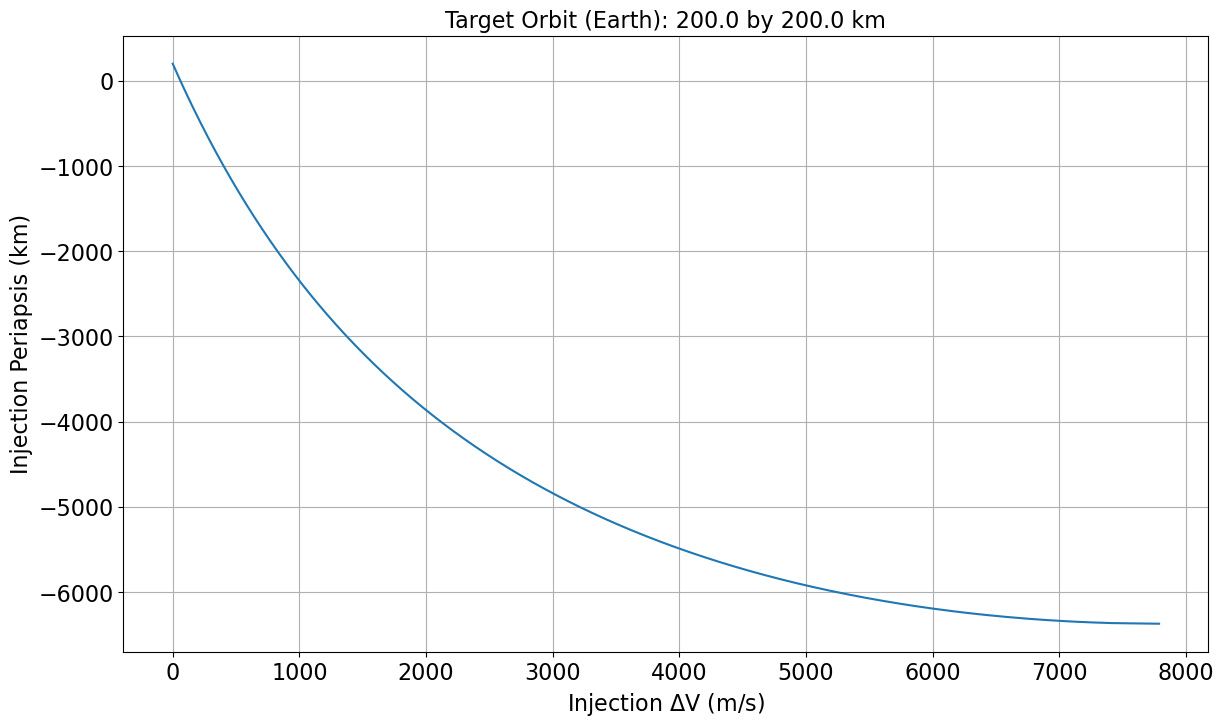

In [29]:
injection_altitudes = np.linspace(200e3,-6371e3,900)
p3.plot_transfers(injection_altitudes,200e3,200e3)